<a href="https://colab.research.google.com/github/SirinootKK/intern/blob/main/ID9_Thai_QA_with_SimpleTransformer_(Wangchanberta).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

How to make Thai QA System using SimpleTransformer
- Pretrain Model: [Wangchanberta](https://medium.com/airesearch-in-th/wangchanberta-%E0%B9%82%E0%B8%A1%E0%B9%80%E0%B8%94%E0%B8%A5%E0%B8%9B%E0%B8%A3%E0%B8%B0%E0%B8%A1%E0%B8%A7%E0%B8%A5%E0%B8%9C%E0%B8%A5%E0%B8%A0%E0%B8%B2%E0%B8%A9%E0%B8%B2%E0%B9%84%E0%B8%97%E0%B8%A2%E0%B8%97%E0%B8%B5%E0%B9%88%E0%B9%83%E0%B8%AB%E0%B8%8D%E0%B9%88%E0%B9%81%E0%B8%A5%E0%B8%B0%E0%B8%81%E0%B9%89%E0%B8%B2%E0%B8%A7%E0%B8%AB%E0%B8%99%E0%B9%89%E0%B8%B2%E0%B8%97%E0%B8%B5%E0%B9%88%E0%B8%AA%E0%B8%B8%E0%B8%94%E0%B9%83%E0%B8%99%E0%B8%82%E0%B8%93%E0%B8%B0%E0%B8%99%E0%B8%B5%E0%B9%89-d920c27cd433)
- Training: [Simple Transformer QA](https://simpletransformers.ai/docs/qa-minimal-start/)
- Author: Kobkrit Viriyayudhakorn [kobkrit@iapp.co.th](mailto:kobkrit@iapp.co.th)
- Written on 14 Apr 2022
-Modified by Kietikul Jearanaitanakij (Apr 23, 2023)
- Later Modified by Sirinoot Ketkham (Jun
 19, 2023)

https://simpletransformers.ai/docs/qa-model/

# **เสร็จแล้ว รอเทรนกับข้อมูลเต็มจำนวน**



> ID8 : update Training & Validation loss Graph add Hyperparameter

ref = https://discuss.pytorch.org/t/what-happens-when-loss-are-negative/47883/3
!! use GPU V100 for Deep Learning !!



# Step 0 : Install dependencies

In [1]:
! pip install -q simpletransformers

^C


In [2]:
! pip install pythainlp

In [2]:
from sklearn.metrics.pairwise import cosine_similarity  # ใช้หาค่าความคล้ายคลึง
import numpy as np
import pandas as pd

In [4]:
#from datasets import load_dataset
#from transformers import AutoTokenizer

dataset_path = "https://raw.githubusercontent.com/SirinootKK/intern/main/dataset/BERTa_ThaiQA_Corpus_Full.csv"

# from google.colab import files,drive
# drive.mount('/content/gdrive')
# dataset_path = '/content/gdrive/MyDrive/data/Full_ThaiQA_Corpus_wangchanberta.csv'

df = pd.read_csv(dataset_path)
df.dropna(inplace=True)
len(df)

50

# Step 1 : Preparing data

In [5]:
from sklearn.model_selection import train_test_split
train, test = train_test_split(df, test_size=0.2, random_state = 217)
train, valid = train_test_split(train, test_size=0.25, random_state = 217)
print(len(train) , ' ' , len(valid), ' ' , len(test))
train.head()

30   10   10


,context,question,answer
23,เท็กแบ็คเดอะไนท์ เพลงของ จัสติน ทิมเบอร์เลก ให...,เท็กแบ็คเดอะไนท์ เพลงของ จัสติน ทิมเบอร์เลก ให...,วันที่ 12 กรกฎาคม ค.ศ. 2013
12,บัดดี้ นอกซ์ มีผลงานเพลงที่เป็นที่รู้จักในช่วง...,บัดดี้ นอกซ์ มีผลงานเพลงที่เป็นที่รู้จักในช่วง...,"เพลง ""Party Doll"""
44,ท้าวสุนิมมิตเป็นจอมเทพของสวรรค์ที่มีชื่อว่าอะไ...,ท้าวสุนิมมิตเป็นจอมเทพของสวรรค์ที่มีชื่อว่าอะไร,นิมมานรดี
22,เท็กแบ็คเดอะไนท์เป็นเพลงที่บันทึกเสียงโดยนักร้...,เท็กแบ็คเดอะไนท์เป็นเพลงที่บันทึกเสียงโดยนักร้...,จัสติน ทิมเบอร์เลก
21,โปรดิวเซอร์ของอัลบั้มตลอดกาล ของวงคีรีบูนคือใค...,โปรดิวเซอร์ของอัลบั้มตลอดกาล ของวงคีรีบูนคือใคร,คุณปราจีน ทรงเผ่า


In [6]:
train_question_id = []
train_article_id = []
valid_question_id = []
valid_article_id = []
test_question_id = []
test_article_id = []

for i in range(len(train)):
  train_question_id.append(str(i))
  train_article_id.append(str(i))

for i in range(len(valid)):
  valid_question_id.append(str(i+len(train)))
  valid_article_id.append(str(i+len(train)))

for i in range(len(test)):
  test_question_id.append(str(i+len(train)+len(valid)))
  test_article_id.append(str(i+len(train)+len(valid)))

In [7]:
# ! pip install datasets

In [7]:
import datasets
from datasets import Dataset
train_set = { 'question_id': train_question_id,
              'article_id': train_article_id,
              'context' : train['context'],
              'question' : train['question'],
              'answer' : train['answer']
              #'answers' : Dataset.from_dict( { 'text': list(train['answer']), 'answer_start': list(train['answer_start'])} )
            }
valid_set = { 'question_id': valid_question_id,
              'article_id': valid_article_id,
              'context' : valid['context'],
              'question' : valid['question'],
              'answer' : valid['answer']
              #'answers' : Dataset.from_dict( { 'text': list(valid['answer']), 'answer_start': list(valid['answer_start'])} )
            }
test_set  = { 'question_id': test_question_id,
              'article_id': test_article_id,
              'context' : test['context'],
              'question' : test['question'],
              'answer' : test['answer']
              #'answers' : Dataset.from_dict( { 'text': list(test['answer']), 'answer_start': list(test['answer_start'])} )
            }
raw_datasets = datasets.DatasetDict({
    'train': Dataset.from_dict(train_set),
    'validation': Dataset.from_dict(valid_set),
    'test': Dataset.from_dict(test_set)})

c:\Users\sirinoot\AppData\Local\Programs\Python\Python311\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [8]:
raw_datasets['train']['context'][0]

'เท็กแบ็คเดอะไนท์ เพลงของ จัสติน ทิมเบอร์เลก ให้ดาวน์โหลดได้เมื่อไร   วันที่ 12 กรกฎาคม ค.ศ. 2013'

In [9]:
import pandas as pd
train_df = pd.DataFrame(raw_datasets['train'])
validation_df = pd.DataFrame(raw_datasets['validation'])
test_df = pd.DataFrame(raw_datasets['test'])

# Step 2 : Word Tokenization

### สร้าง convert_to_simpletransformer_format
 method ไว้สำหรับแปลง format  Data เราให้ใช้กับ model Transformer ได้

In [10]:
import json
from pythainlp.tokenize import word_tokenize

In [11]:
def convert_to_simpletransformer_format(df):
  all = {}
  for (idx, row) in df.iterrows():
    #print('*******')
    #print(row)
    #print('#######')
    answers = row["answer"]
    if (row["article_id"] not in all):
      all[row["article_id"]] = {"context": " ".join(word_tokenize(row['context'],engine="newmm-safe")), "qas":[]}
    question_text = " ".join(word_tokenize(row['question'],engine="newmm-safe"))
    #answer_text = " ".join(word_tokenize(answers["text"][0],engine="newmm-safe"))
    answer_text = " ".join(word_tokenize(answers,engine="newmm-safe"))
    try:
      answer_start = all[row["article_id"]]["context"].index(answer_text)
      all[row["article_id"]]["qas"].append({"id":row["question_id"], "is_impossible": False, "question": question_text, "answers": [{"text":answer_text, "answer_start": answer_start}]})
    except Exception as e:
      print("Context:" +all[row["article_id"]]["context"])
      print("Answer:" +answer_text)
      print("Exception:" +str(e))
  return list(all.values())

### ทดลองใช้ convert_to_simpletransformer_format

In [13]:
# test_df

#### Format data หลังทำการ convert to simpletransformer

In [12]:
convert_to_simpletransformer_format(test_df)

[{'context': 'เพลง   สเตย์ วิธ มี   ประกอบ ละคร เรื่อง   ก็ อบ ลิ น   คำสาป รัก ผู้พิทักษ์ วิญญาณ    ใคร เป็น ผู้ ขับร้อง     แพ   จิน - ย็อง',
  'qas': [{'id': '40',
    'is_impossible': False,
    'question': 'เพลง   สเตย์ วิธ มี   ประกอบ ละคร เรื่อง   ก็ อบ ลิ น   คำสาป รัก ผู้พิทักษ์ วิญญาณ    ใคร เป็น ผู้ ขับร้อง',
    'answers': [{'text': 'แพ   จิน - ย็อง', 'answer_start': 112}]}]},
 {'context': 'การแข่งขัน ฟุตบอล ชิงแชมป์ แห่งชาติ ยุโรป   1980   จัด การแข่งขัน ขึ้น เมื่อไร     วันที่   11 - 22   มิถุนายน   ค.ศ.   1980',
  'qas': [{'id': '41',
    'is_impossible': False,
    'question': 'การแข่งขัน ฟุตบอล ชิงแชมป์ แห่งชาติ ยุโรป   1980   จัด การแข่งขัน ขึ้น เมื่อไร',
    'answers': [{'text': 'วันที่   11 - 22   มิถุนายน   ค.ศ.   1980',
      'answer_start': 83}]}]},
 {'context': 'เครื่อง อิสริยาภรณ์ ดารา มหา ปุ ตรา เป็น เครื่อง อิสริยาภรณ์ ของ ประเทศ อินโดนีเซีย มี ลำดับ เกียรติ เป็น อันดับ ที่ เท่าไร     อันดับ ที่   2',
  'qas': [{'id': '42',
    'is_impossible': False,
    'qu

# Step 3 : Train the model

https://simpletransformers.ai/docs/qa-model/

In [15]:
import logging
import torch

from simpletransformers.question_answering import QuestionAnsweringModel, QuestionAnsweringArgs


logging.basicConfig(level=logging.INFO)
transformers_logger = logging.getLogger("transformers")
transformers_logger.setLevel(logging.WARNING)

train_data = convert_to_simpletransformer_format(train_df)
validation_data = convert_to_simpletransformer_format(validation_df)
test_data = convert_to_simpletransformer_format(test_df)

# Configure the model
model_args = QuestionAnsweringArgs()

model_args.loss_type = 'cross_entropy'

model_args.evaluate_during_training = True
model_args.save_best_model = True
model_args.overwrite_output_dir = True

model_args.train_batch_size = 16
model_args.num_train_epochs = 5
model_args.eval_batch_size = 16

model_args.dropout = 0.1
model_args.weight_decay = 0.01
model_args.learning_rate = 1e-05
model_args.adam_epsilon = 1e-06
# model_args.gradient_accumulation_steps = 8

model = QuestionAnsweringModel(
    "camembert", "airesearch/wangchanberta-base-att-spm-uncased", args=model_args, use_cuda=torch.cuda.is_available()
)

Context:เขา เอ๋อ เหมย์   หรือ   ภูเขา ง้อไบ๊   ในประเทศ จีน มี ความสูง เท่าไร     3
Answer:3,099   เมตร
Exception:substring not found


Some weights of the model checkpoint at airesearch/wangchanberta-base-att-spm-uncased were not used when initializing CamembertForQuestionAnswering: ['lm_head.dense.bias', 'lm_head.bias', 'lm_head.layer_norm.weight', 'lm_head.decoder.weight', 'lm_head.dense.weight', 'lm_head.layer_norm.bias', 'lm_head.decoder.bias']
- This IS expected if you are initializing CamembertForQuestionAnswering from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing CamembertForQuestionAnswering from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of CamembertForQuestionAnswering were not initialized from the model checkpoint at airesearch/wangchanberta-base-att-spm-uncased and are newly initialized: ['qa_outputs.bias', 

In [16]:
# ! pip install wandb -qq
# import wandb
# import traceback

# Set the WANDB_TEAM environment variable
# WANDB_API_KEY='5a6baf1210ed659768873e6c4f21ff540162cb77'
# wandb.login(key=WANDB_API_KEY)
# wandb.init(
#     entity="chatbot-chanan",
#     resume=True,
#     # id = '0iq9gkcj',
#     project="WangchanBERTa",
#     name="i9_test2_ori"
#     )

env: WANDB_API_KEY='5a6baf1210ed659768873e6c4f21ff540162cb77'


NameError: name 'WANDB_API_KEY' is not defined

In [ ]:
# try:
model.train_model(train_data, eval_data=validation_data)
result, texts = model.eval_model(test_data)
#   wandb.save('/content/outputs/best_model/training_args.bin')
#   wandb.save('/content/outputs/best_model/pytorch_model.bin')
#   wandb.save('/content/outputs/training_progress_scores.csv')

# except Exception as e:
#   traceback.print_exc()
#   wandb.save("/content/outputs/training_args.bin")
#   wandb.save('/content/outputs/pytorch_model.bin')
#   try:
#     wandb.save('/content/outputs/training_progress_scores.csv')
#   except Exception as e:
#     print('error to save the scores file!!')
#     # wandb.finish()


INFO:simpletransformers.question_answering.question_answering_model: Converting to features started.


Epochs 0/5. Running Loss:    3.8150: 100%|██████████| 19/19 [01:44<00:00,  5.50s/it]
INFO:simpletransformers.question_answering.question_answering_model: Converting to features started.
Epochs 1/5. Running Loss:    2.7606: 100%|██████████| 19/19 [01:42<00:00,  5.39s/it]
INFO:simpletransformers.question_answering.question_answering_model: Converting to features started.
Epochs 2/5. Running Loss:    1.5162: 100%|██████████| 19/19 [01:37<00:00,  5.13s/it]
INFO:simpletransformers.question_answering.question_answering_model: Converting to features started.
Epochs 3/5. Running Loss:    0.8034: 100%|██████████| 19/19 [01:33<00:00,  4.90s/it]
INFO:simpletransformers.question_answering.question_answering_model: Converting to features started.
Epochs 4/5. Running Loss:    0.4789: 100%|██████████| 19/19 [01:33<00:00,  4.91s/it]
INFO:simpletransformers.question_answering.question_answering_model: Converting to features started.
Epoch 5 of 5: 100%|██████████| 5/5 [11:03<00:00, 132.69s/it]
INFO:simp

In [ ]:
# Make predictions with the model
to_predict = [
    {
        "context": "ฟักแฟง ชาร์จ แบต อยู่",
        "qas": [
            {
                "question": "ฟักแฟง ทำ อะไร",
                "id": "0",
            }
        ],
    }
]

answers, probabilities = model.predict(to_predict)

print(answers)
print(probabilities)

INFO:simpletransformers.question_answering.question_answering_model: Converting to features started.
Running Prediction: 100%|██████████| 1/1 [00:00<00:00,  6.28it/s]

[{'id': '0', 'answer': ['ฟักแฟง ชาร์จ แบต อยู่', 'ฟักแฟง ชาร์จ แบต', 'ฟักแฟง', 'แบต อยู่', 'อยู่', 'ชาร์จ แบต อยู่', 'แบต', 'ชาร์จ แบต', 'ฟักแฟง ชาร์จ', 'ชาร์จ', 'ง', 'แฟ', 'ฟัก']}]
[{'id': '0', 'probability': [0.16355013593158943, 0.1339659157251254, 0.12416279138754688, 0.11246882296975606, 0.09648370170287397, 0.09422069860774468, 0.09212458781429986, 0.07717732606793619, 0.05540565765243265, 0.03191901823314496, 0.008293765363806336, 0.005997986132126755, 0.003829358889136365]}]


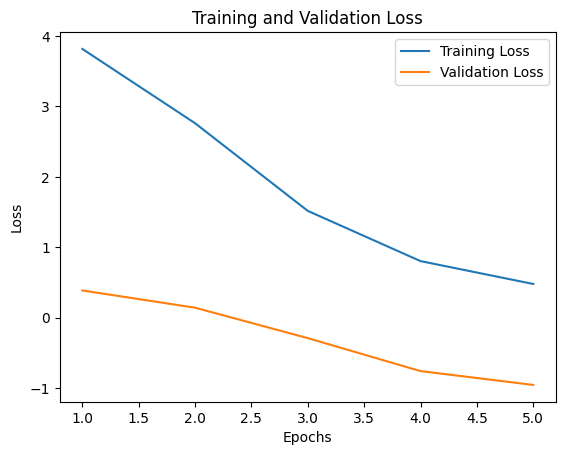

In [ ]:
#@title Graph
import pandas as pd
import matplotlib.pyplot as plt

# Read the CSV file
train_valid_loss = pd.read_csv('./outputs/training_progress_scores.csv')

# Extract the train_loss and eval_loss columns
train_loss = train_valid_loss['train_loss']
eval_loss = train_valid_loss['eval_loss']

# for epoch, (train, eval) in enumerate(zip(train_loss, eval_loss)):
#     wandb.log({"train_loss": train, "eval_loss": eval})

# Create a list of epochs (assuming it is a sequential index)
epochs = train_valid_loss.index + 1

# Plot the training loss and evaluation loss
plt.plot(epochs, train_loss, label='Training Loss')
plt.plot(epochs, eval_loss, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

# Build Chatbot by finding the most similar document using Thai2Vec

In [ ]:
from pythainlp import word_tokenize # ทำการเรียกตัวตัดคำ
#from pythainlp.word_vector import * # ทำการเรียก thai2vec
from sklearn.metrics.pairwise import cosine_similarity  # ใช้หาค่าความคล้ายคลึง
import numpy as np
from pythainlp import word_vector
wv_model = word_vector.WordVector(model_name="thai2fit_wv").get_model() # load thai2fit_wv from pythainlp

#create dataframe
thai2dict = {}
for word in wv_model.index_to_key:
    thai2dict[word] = wv_model[word]
thai2vec = pd.DataFrame.from_dict(thai2dict,orient='index')
thai2vec.head(10)

INFO:gensim.models.keyedvectors:loading projection weights from C:\Users\sirinoot\pythainlp-data\thai2vec.bin
INFO:gensim.utils:KeyedVectors lifecycle event {'msg': 'loaded (51358, 300) matrix of type float32 from C:\\Users\\sirinoot\\pythainlp-data\\thai2vec.bin', 'binary': True, 'encoding': 'utf8', 'datetime': '2023-06-19T12:12:50.959158', 'gensim': '4.3.1', 'python': '3.11.3 (tags/v3.11.3:f3909b8, Apr  4 2023, 23:49:59) [MSC v.1934 64 bit (AMD64)]', 'platform': 'Windows-10-10.0.22621-SP0', 'event': 'load_word2vec_format'}


,0,1,2,3,4,5,6,7,8,9,...,290,291,292,293,294,295,296,297,298,299
ที่,0.308956,-0.097699,0.116745,0.215612,0.015768,-0.064163,0.062168,0.039649,0.864940,0.846904,...,-0.142418,0.033241,0.171581,-0.624864,-0.009358,0.449131,0.120130,-0.122195,-0.450617,-0.071318
และ,0.010751,-0.618971,0.129665,0.035460,-0.007560,0.027607,0.397824,0.026543,0.254075,0.168328,...,-0.105786,0.180930,-0.101630,0.070885,-0.037263,0.183606,-0.049088,-0.672288,-1.293044,0.592576
เป็น,-0.015736,-0.258926,0.052953,0.153728,-0.005985,-0.021081,0.041088,0.057312,1.633230,0.442729,...,-0.009408,-0.252576,-0.305512,0.372542,0.049151,0.568470,0.266586,0.400800,-0.784650,0.197369
ของ,-0.189711,-0.174774,0.171124,-0.186771,0.054294,-0.114150,-1.109456,-0.094466,-0.447015,0.042377,...,-0.168676,-0.148738,0.680404,0.097702,0.020270,0.182967,-0.083949,0.006287,-0.707434,-0.070234
มี,-0.156962,-0.231863,0.080312,0.323157,0.215695,0.055145,0.420794,0.016842,0.256759,0.832864,...,-0.044267,-0.147186,-0.105424,0.907078,0.009299,0.550953,0.139337,0.031696,-0.670379,-0.008048
ได้,-0.428813,-0.031194,0.041922,-0.036608,-0.008106,0.076470,-0.782270,0.033361,0.606864,0.440520,...,0.024458,-0.025031,0.103389,-0.078255,0.034323,0.459774,-0.748643,0.337775,-0.487408,-0.511535
"""""""""",-0.287710,0.064193,0.205076,0.146356,-0.071343,-0.039451,-1.845461,0.163763,1.018096,0.272786,...,0.051024,-0.532856,-0.131856,-0.090323,-0.058895,0.151262,-0.420358,0.055971,-0.930814,0.163908
การ,0.239587,-0.303620,0.079953,-0.453045,-0.528826,-0.161692,0.235725,-0.099673,0.691668,0.536159,...,-0.110436,-0.297495,-0.217414,0.045158,0.066647,0.190095,-0.304333,-0.724927,-0.995488,-0.716609
(,-0.120522,-0.355783,0.168180,-0.377733,-0.158624,-0.047249,0.361140,0.161460,0.913314,0.345037,...,0.116285,-0.318218,-0.356664,0.519889,0.130475,0.125772,0.101328,-0.382658,-1.205359,0.340139
),-0.086848,-0.155231,0.133015,-0.039913,0.183761,0.115142,-1.940854,-0.066565,-2.399744,0.146722,...,0.019406,-0.181474,0.099863,0.516092,0.201697,0.249139,0.252957,1.138815,-0.018209,0.232265


In [ ]:
def sentence_vectorizer(ss,dim=300,use_mean=True): # ประกาศฟังก์ชัน sentence_vectorizer
    s = word_tokenize(ss)
    vec = np.zeros((1,dim))
    for word in s:
        if word in wv_model.index_to_key:
            vec+= wv_model.get_vector(word)
        else: pass
    if use_mean: vec /= len(s)
    return vec
def sentence_similarity(s1,s2):
    return cosine_similarity(sentence_vectorizer(str(s1)),sentence_vectorizer(str(s2)))
    #return np.dot( np.array(sentence_vectorizer(str(s1))) , np.array(sentence_vectorizer(str(s2))) )

In [ ]:
sentence_similarity("สวัสดีครับ", "สวัสดีคร้าบ")

array([[0.72666795]])

# Step 4 : Make predictions with the model


In [ ]:
# Make predictions with the model

question = "พิกซาร์สตูดิโอตั้งอยู่ที่เมืองอะไร"
#tokenized_question = word_tokenize(question)
MostSimilarContext = ""
max_sim = 0

for c in df['context']:
  #tokenized_c = word_tokenize(c)
  #print(c)
  sim = sentence_similarity(question, c)
  if max_sim < sim:
    max_sim = sim
    MostSimilarContext = c

print(MostSimilarContext)
print(max_sim)

to_predict = [
    {
        #"context" : context,
        "context" : MostSimilarContext,
        "qas": [
            {
                "question": question,
                "id": "0",
            }
        ],
    }
]

answers, probabilities = model.predict(to_predict)

print(answers)
print(probabilities)

INFO:simpletransformers.question_answering.question_answering_model: Converting to features started.


สภาแห่งชาติเซเนกัล ตั้งอยู่ที่เมืองอะไร   เมืองดาการ์
[[0.75493888]]


Running Prediction: 100%|██████████| 1/1 [00:00<00:00,  5.68it/s]

[{'id': '0', 'answer': ['เมืองดาการ์', 'ตั้งอยู่ที่เมืองอะไร เมืองดาการ์', 'การ์', 'สภาแห่งชาติเซเนกัล ตั้งอยู่ที่เมืองอะไร เมืองดาการ์', 'ตั้งอยู่ที่เมืองอะไร', 'สภาแห่งชาติเซเนกัล', 'กัล', 'เมือง', 'า', 'สภา', 'สภาแห่งชาติเซเนกัล ตั้งอยู่ที่เมืองอะไร', 'ด', 'ที่เมือง', 'เน', 'อะไร', 'เซ']}]
[{'id': '0', 'probability': [0.5710200550525705, 0.266465293233052, 0.04706174767847669, 0.035225966523025794, 0.027379232098903285, 0.014960148819028513, 0.012705472188663957, 0.004125876458499833, 0.004084974054224525, 0.004014094837722279, 0.00361945791003483, 0.002463895144859194, 0.0022556637153466805, 0.0017014361969752052, 0.0014530536436511794, 0.0014067318799733778]}]


# Step 5 : Evaluate the model

In [ ]:
def predict(model,question):
  question = question
  #tokenized_question = word_tokenize(question)
  MostSimilarContext = ""
  max_sim = 0

  for c in df['context']:
    #tokenized_c = word_tokenize(c)
    #print(c)
    sim = sentence_similarity(question, c)
    if max_sim < sim:
      max_sim = sim
      MostSimilarContext = c

  # print(MostSimilarContext)
  # print(max_sim)

  to_predict = [
      {
          #"context" : context,
          "context" : MostSimilarContext,
          "qas": [
              {
                  "question": question,
                  "id": "0",
              }
          ],
      }
  ]

  answers, probabilities = model.predict(to_predict)

  # print(answers)
  # print(probabilities)
  return answers[0]["answer"][0]

In [ ]:
from sklearn import metrics
from sklearn.metrics import classification_report
from sklearn.metrics import precision_recall_fscore_support as score

In [ ]:
#@title predict all test data and save y_list to wandb
import os

current_dir = os.getcwd()

file_name = 'y_list.txt'
file_path = os.path.join(current_dir, file_name)

y_pred_ls = []
y_true_ls = []
accls=[]
precls = []
recls=[]
f1ls=[]
# try:
for i in range(len(test_data)):
    # print('=====================',i,'===================')
  y_pred = predict(model,test_data[i]["qas"][0]['question'])
    # y_true = test_data[i]["qas"][0]['answers'][0]['text']
  y_true = test_df.iloc[i][4]
  y_pred_ls.append(y_pred)
  y_true_ls.append(y_true)

  with open(file_path, 'a') as file:
    file.write(f'Loop at {i}:\n')
    file.write(f'y_pred: {y_pred}\n')
    file.write(f'y_true: {y_true}\n')
    file.write('=====================\n')

    # wandb.save("y_list.txt")

# except Exception as e:
#   traceback.print_exc()
#   wandb.save("path_to_error_model")
  # wandb.finish()


INFO:simpletransformers.question_answering.question_answering_model: Converting to features started.
Running Prediction: 100%|██████████| 1/1 [00:00<00:00,  8.52it/s]
Traceback (most recent call last):
  File "C:\Users\sirinoot\AppData\Local\Temp\ipykernel_17244\1409850430.py", line 30, in <module>
    wandb.save("y_list.txt")
  File "c:\Users\sirinoot\AppData\Local\Programs\Python\Python311\Lib\site-packages\wandb\sdk\wandb_run.py", line 342, in wrapper_fn
    return func(self, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\sirinoot\AppData\Local\Programs\Python\Python311\Lib\site-packages\wandb\sdk\wandb_run.py", line 332, in wrapper
    return func(self, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\sirinoot\AppData\Local\Programs\Python\Python311\Lib\site-packages\wandb\sdk\wandb_run.py", line 1780, in save
    return self._save(glob_str, base_path, policy)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "c:\Users\sirin

In [ ]:
len(y_true_ls),len(y_pred_ls)

(1, 1)

In [ ]:
result_df = pd.DataFrame()

result_df['y_true'] = y_true_ls
result_df['y_pred'] = y_pred_ls

# result_df

#Step 6 : Measure Performance
- Bleu
- Bluert
- Rouge : Rouge-L Rouge-1 Rouge-2
- accuracy
- precision
- recalls
- f1

In [ ]:
#@title installation
! pip install rouge --q
! git clone https://github.com/google-research/bleurt.git
%cd bleurt
! pip install .

In [ ]:
from nltk.translate.bleu_score import sentence_bleu
from statistics import mean
import pythainlp

In [ ]:
reference_sentences = y_true_ls
candidate_sentences = y_pred_ls

reference_tokens = [pythainlp.word_tokenize(sentence, engine='newmm-safe') for sentence in reference_sentences]
candidate_tokens = [pythainlp.word_tokenize(sentence, engine='newmm-safe') for sentence in candidate_sentences]


bleu_scores = []
for reference, candidate in zip(reference_tokens, candidate_tokens):
    score = sentence_bleu([reference], candidate, weights=(1, 0, 0, 0))
    bleu_scores.append(score)

# for i, score in enumerate(bleu_scores):
#     print(f"BLEU score row# {i+1}: {score}")

print('BLEU score -> {}'.format(mean(bleu_scores)))

BLEU score -> 1.0


c:\Users\sirinoot\AppData\Local\Programs\Python\Python311\Lib\site-packages\nltk\translate\bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 3-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
c:\Users\sirinoot\AppData\Local\Programs\Python\Python311\Lib\site-packages\nltk\translate\bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)


In [ ]:
def tokenize_text_for_blurt (text):
  return " ".join(pythainlp.word_tokenize(text,engine="newmm-safe"))

In [ ]:
ref_cand_token = pd.DataFrame()

ref_cand_token['y_true_tk'] = y_true_ls
ref_cand_token['y_pred_tk'] = y_pred_ls

ref_cand_token['y_true_tk'] = ref_cand_token['y_true_tk'].apply(tokenize_text_for_blurt)
ref_cand_token['y_pred_tk'] = ref_cand_token['y_pred_tk'].apply(tokenize_text_for_blurt)
# ref_cand_token = tokenize_text_for_blurt(ref_cand_token)

ref_cand_token

,y_true_tk,y_pred_tk
0,จังหวัด มหาสารคาม,จังหวัด มหาสารคาม


In [ ]:
from bleurt import score

checkpoint = "bleurt/test_checkpoint"
references = ref_cand_token['y_true_tk']
candidates = ref_cand_token['y_pred_tk']

scorer = score.BleurtScorer(checkpoint)
bleurt_scores = scorer.score(references=references, candidates=candidates)
assert isinstance(bleurt_scores, list) and len(bleurt_scores) == len(bleurt_scores)
print('BLEURT Score -> {}'.format(mean(bleurt_scores)))

INFO:tensorflow:Reading checkpoint bleurt/test_checkpoint.
INFO:tensorflow:Config file found, reading.
INFO:tensorflow:Will load checkpoint dbleurt_tiny
INFO:tensorflow:Loads full paths and checks that files exists.
INFO:tensorflow:... name:dbleurt_tiny
INFO:tensorflow:... vocab_file:vocab.txt
INFO:tensorflow:... bert_config_file:bert_config.json
INFO:tensorflow:... do_lower_case:True
INFO:tensorflow:... max_seq_length:512
INFO:tensorflow:Creating BLEURT scorer.
INFO:tensorflow:Creating WordPiece tokenizer.


INFO:tensorflow:WordPiece tokenizer instantiated.
INFO:tensorflow:Creating Eager Mode predictor.
INFO:tensorflow:Loading model.
INFO:tensorflow:BLEURT initialized.


BLEURT Score -> 0.9275933504104614


In [ ]:
from rouge import Rouge
rouge = Rouge()

num = 0

# Calculate Rouge score for each sentence pair
for ref, cand, daf, pred_ls in zip(ref_cand_token['y_true_tk'], ref_cand_token['y_pred_tk'],test_df['context'],y_pred_ls):
    scores = rouge.get_scores(ref, cand)
    cand_con = rouge.get_scores(daf, pred_ls)
    # print(f"Rouge-L score: {scores}")
    rouge_l_scores = scores[0]['rouge-l']['f']
    rouge_1_scores = scores[0]['rouge-1']['f']
    rouge_2_scores = scores[0]['rouge-2']['f']

    # avg_rouge_l_score = sum(rouge_l_scores) / len(rouge_l_scores)
    # avg_rouge_1_score = sum(rouge_1_scores) / len(rouge_1_scores)
    # avg_rouge_2_score = sum(rouge_2_scores) / len(rouge_2_scores)

    con_scores= cand_con[0]['rouge-l']['f']

    # print(rouge_l_scores, num,cand)
    # print('context vs cand => {} i => {}' .format(con_scores, num))
    # print("=================================")

    if(rouge_l_scores > 0.5 and con_scores < 0.9):
      num += 1
      # acc_ls.append(rouge_l_scores)
      # print('index {}, rougeL {}' .format(num, rouge_l_scores))


acc = num/len(y_true_ls)

print('accuracy -> {}'.format(acc))
print('precision -> {}'.format(metrics.precision_score(y_true_ls,y_pred_ls,average='macro')))
print('recall -> {}'.format(metrics.recall_score(y_true_ls,y_pred_ls,average='macro')))
print('f1 score -> {}'.format(metrics.f1_score(y_true_ls,y_pred_ls,average='macro')))
print('ROUGE-1 -> {}' .format(rouge_1_scores))
print('ROUGE-2 -> {}' .format(rouge_2_scores))
print('ROUGE-L -> {}' .format(rouge_l_scores))
print('BLEURT Score -> {}'.format(mean(bleurt_scores)))
print('BLEU score -> {}'.format(mean(bleu_scores)))
# wandb.save('outputs.log')
# wandb.finish()

accuracy -> 1.0
precision -> 1.0
recall -> 1.0
f1 score -> 1.0
ROUGE-1 -> 0.999999995
ROUGE-2 -> 0.999999995
ROUGE-L -> 0.999999995
BLEURT Score -> 0.9275933504104614
BLEU score -> 1.0


eval_loss,█▇▄▂▁
train_loss,█▆▃▂▁
eval_loss,-0.95391
train_loss,0.47895


#wandb

In [ ]:
# Log the train_loss and eval_loss values
# for epoch, (train, eval) in enumerate(zip(train_loss, eval_loss)):
#     wandb.log({"train_loss": train, "eval_loss": eval})
# wandb.init(
#     entity="chatbot-chanan",
#     resume=True,
#     # id = '0iq9gkcj',
#     project="WangchanBERTa",
#     name="i9_test2_ori"
# )
# wandb.save('/intern/WangChanBERTa/outputs/')
# wandb.save('d:\\intern\\WangChanBERTa\\bleurt\\wandb\\run-20230619_122710-yb01egem\\files\\y_list.txt')
# wandb.finish()
